In [4]:
import yfinance as yf
import numpy as np
import scipy.stats as si
import matplotlib.pyplot as plt
import random 
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns


In [5]:
"""
On sept 13 @3:15pm I got live options prices for a range of stocks. These prices where for a range of expiration dates within 30 days and all possible strike prices. I also computed BS prediction for these options prices.

The data has been saved to files for later use. 

In 30 days time we will get the live stock price on the date of option expiration. With this we should be able to see how much you would have won/lost given you purchased the stock at the live price or used the BS prediction. 

The BS model is giving an estiamte for the price of the option so it will either be suggestion the market rate is at a discount or over priced. We can see how large the gains/losses would have been if we purchased all 'discounted' stocks. 

We can see how often the dicount vs over price label was correct. For instance if BS said discount indicating that you should buy, but you loose, that is a -1, if it said overpriced and you didnt buy but if you did buy you wouldve lost, +1 point etc

We can also compare the total gain/loss obtained by purchasing all options based on BS model vs market price (not realsitic market stretgy but gives indication of how the model is performing)

"""

#prove that black scholes formulae work by subbing into the equation https://www.columbia.edu/~mh2078/FoundationsFE/BlackScholes.pdf



"\nOn sept 13 @3:15pm I got live options prices for a range of stocks. These prices where for a range of expiration dates within 30 days and all possible strike prices. I also computed BS prediction for these options prices.\n\nThe data has been saved to files for later use. \n\nIn 30 days time we will get the live stock price on the date of option expiration. With this we should be able to see how much you would have won/lost given you purchased the stock at the live price or used the BS prediction. \n\nThe BS model is giving an estiamte for the price of the option so it will either be suggestion the market rate is at a discount or over priced. We can see how large the gains/losses would have been if we purchased all 'discounted' stocks. \n\nWe can see how often the dicount vs over price label was correct. For instance if BS said discount indicating that you should buy, but you loose, that is a -1, if it said overpriced and you didnt buy but if you did buy you wouldve lost, +1 point e

In [6]:
r = 0.0525 #US RISK FREE INTEREST RATE https://www.fool.com/the-ascent/federal-reserve-interest-rates/

tickers = [
    # US Stocks
    "NVDA",  # Nvidia
    "AAPL",  # Apple
    "GOOG",  # Alphabet
    "TSLA",  # Tesla
    "AMZN",  # Amazon
    "MSFT",  # Microsoft
    "META",  # Meta Platforms
    "AVGO",  # Broadcom
    "CRM",
    "NFLX",
    "KO", "JPM","CVX","BA","WMT",

    
    # London Stock Exchange Stocks
    "SHEL",  # Shell
    "AV.",   # Aviva
    "STAN",  # Standard Chartered
    "RR",    # Rolls-Royce Holdings
    "IAG",   # International Consolidated Airlines Group
    "BP",    # BP
    "BDEV",  # Barratt Developments
    "JD",    # JD Sports Fashion
    "AUTO",  # Auto Trader Group
    "SMDS",  # DS Smith Plc
    "MNG",   # M&G Plc
    
    # ASX Stocks
    "FMG",   # Fortescue Metals
    "WDS",   # Woodside Energy
    "BHP",   # BHP Group
    "CSL",   # CSL Limited
    "PLS",   # Pilbara Minerals
    "MIN",   # Mineral Resources
    "TLX",   # Telix Pharmaceuticals
    "STO",   # Santos
    "RED",   # Red 5 Limited
    "AKE",   # Allkem
    
    # Hong Kong Stock Exchange Stocks
    "1686",  # SUNeVision Holdings
    "2382",  # Sunny Optical Technology
    "9926",  # Akeso
    "788",   # China Tower Corporation
    "762",   # China Unicom
    "1093",  # CSPC Pharmaceutical Group
    "2331",  # Li Ning Co Ltd
    "981",   # SMIC (Semiconductor Manufacturing International Corp)
    
    # German Stock Exchange (DAX)
    "BMW",    # BMW Group
    "IFX",    # Infineon Technologies
    "SAP",    # SAP SE
    "RWE",    # RWE AG
    "VOW",    # Volkswagen AG
    "DTE",    # Deutsche Telekom
    "SIE",    # Siemens AG
    "BAS",    # BASF SE
    "LIN",    # Linde plc
    "FME",    # Fresenius Medical Care AG
    
    # Switzerland
    "SREN",   # Swiss Re AG
    "SLHN",   # Swiss Life Holding AG
    "ZURN",   # Zurich Insurance Group
    "GEBN",   # Geberit AG
    "VACN",   # VAT Group AG
    
    # Singapore
    "DBS",    # DBS Group Holdings
    "OCBC",   # Oversea-Chinese Banking Corporation
    "SGX",    # Singapore Exchange
    "UOB",    # United Overseas Bank
    "SIA",    # Singapore Airlines
    
    # Canada
    "SHOP",   # Shopify
    "ENB",    # Enbridge Inc
    "TD",     # Toronto-Dominion Bank
    "BNS",    # Bank of Nova Scotia
    "CNQ"     # Canadian Natural Resources Limited
]


valid_tickers = []  # A list to store valid tickers with non-empty option dates

for ticker in tickers:
    # Find list of on-market expiration dates between now and 30 days from now

    ticker_obj = yf.Ticker(ticker)
    options_dates = list(ticker_obj.options)

    # Check if the options_dates list is not empty
    if options_dates:
        valid_tickers.append(ticker)  # Append only valid tickers
        

print(f"List of {len(valid_tickers)} Globally Trending Stocks on Yahoo Finance")


List of 30 Globally Trending Stocks on Yahoo Finance


In [7]:


def fetch_historical_stock_data(ticker_symbol):
    # Create a YF Finance Ticker object
    ticker = yf.Ticker(ticker_symbol)
    # Fetch historical market data
    return ticker.history(period="1y") 

def calculate_historical_volatility(stock_data, window=252):
    #Historical voltility using the definition from https://en.wikipedia.org/wiki/Volatility_(finance)
    log_returns = np.log(stock_data['Close'] / stock_data['Close'].shift(1))
    volatility = np.sqrt(window) * log_returns.std()
    return volatility

class BlackScholesModel:
    def __init__(self, S, K, T_days, r, sigma):
        self.S = S        # Underlying asset price
        self.K = K        # Option strike price
        self.T = T_days / 365    # Time to expiration in years (converting days to years)
        self.r = r        # Risk-free interest rate
        self.sigma = sigma  # Volatility of the underlying asset

    def d1(self):
        return (np.log(self.S / self.K) + (self.r + 0.5 * self.sigma ** 2) * self.T) / (self.sigma * np.sqrt(self.T))
    
    def d2(self):
        return self.d1() - self.sigma * np.sqrt(self.T)
    
    def call_option_price(self):
        return (self.S * si.norm.cdf(self.d1(), 0.0, 1.0) - self.K * np.exp(-self.r * self.T) * si.norm.cdf(self.d2(), 0.0, 1.0))
    
    def put_option_price(self):
        return (self.K * np.exp(-self.r * self.T) * si.norm.cdf(-self.d2(), 0.0, 1.0) - self.S * si.norm.cdf(-self.d1(), 0.0, 1.0))


def compute_option_price(ticker_symbol, T, K, option_type):
    stock_data = fetch_historical_stock_data(ticker_symbol)
    
    sigma = calculate_historical_volatility(stock_data, window=252)

    
    bsm = BlackScholesModel(S=fetch_historical_stock_data(ticker_symbol)['Close'][-1], K=K, T_days=T, r=r, sigma=sigma)
    
    if option_type == 'put':
        return bsm.put_option_price()
    else:
        return bsm.call_option_price()



def days_until(date_str):
    """
    Calculate the number of days between today and the given date, ignoring the time component.
    
    Parameters:
    - date_str: Target date as a string in 'YYYY-MM-DD' format.
    
    Returns:
    - Number of days between today and the target date.
    """
    # Parse the input date string into a datetime object
    target_date = datetime.strptime(date_str, '%Y-%m-%d').date()
    
    # Get the current date (only the date part, ignore the time)
    today = datetime.today().date()
    
    # Calculate the difference in days
    delta = target_date - today
    
    # Return the number of days
    return delta.days


def parse_contract_symbol(option_str, ticker):
    """
    Parse the option string into its components.
    
    Parameters:
    - option_str: A string like 'AAPL230616C00195000'
    
    Returns:
    - A dictionary with the components: underlying, expiration date, option type, strike price.
    """
    # Extract the components
    length_ticker = len(ticker)
    expiration_date = option_str[length_ticker: length_ticker+6]  # Next 6 characters (YYMMDD)
    option_type = option_str[length_ticker+6]  # 11th character (C or P)
    strike_price = option_str[length_ticker+7:]  # Rest of the string
    
    # Convert strike price to a float by dividing by 1000
    strike_price_float = int(strike_price) / 1000
    
    # Format expiration date (convert YYMMDD to YYYY-MM-DD)
    expiration_year = "20" + expiration_date[:2]
    expiration_month = expiration_date[2:4]
    expiration_day = expiration_date[4:6]
    formatted_expiration_date = f"{expiration_year}-{expiration_month}-{expiration_day}"
    
    # Return the parsed components
    return {
        'expiration_date': formatted_expiration_date,
        'option_type': option_type,
        'strike_price': strike_price_float
    }


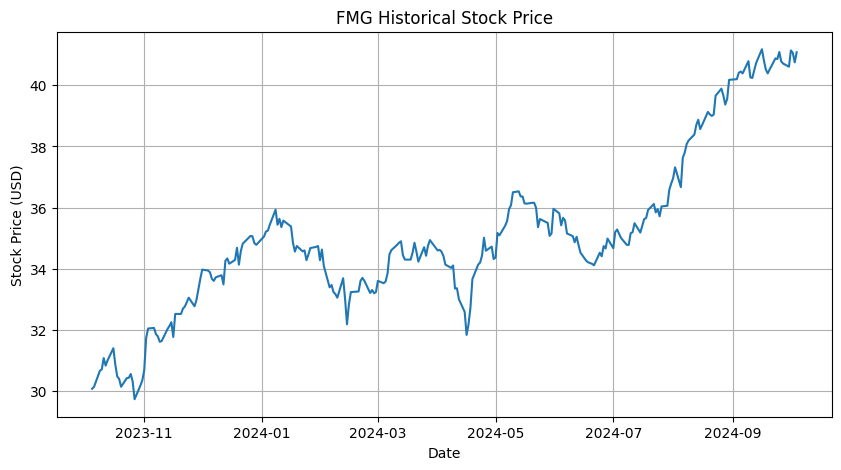

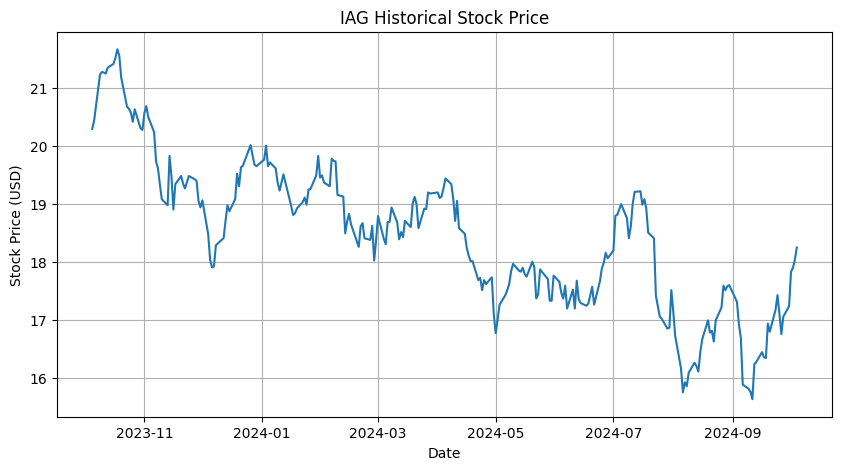

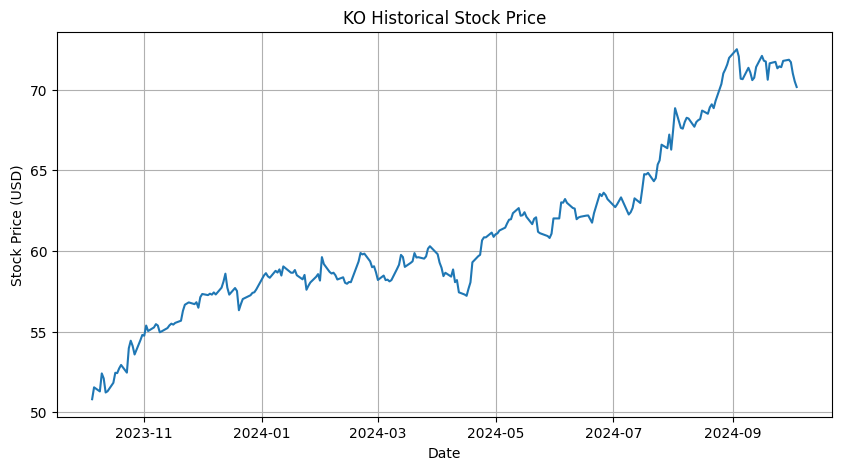

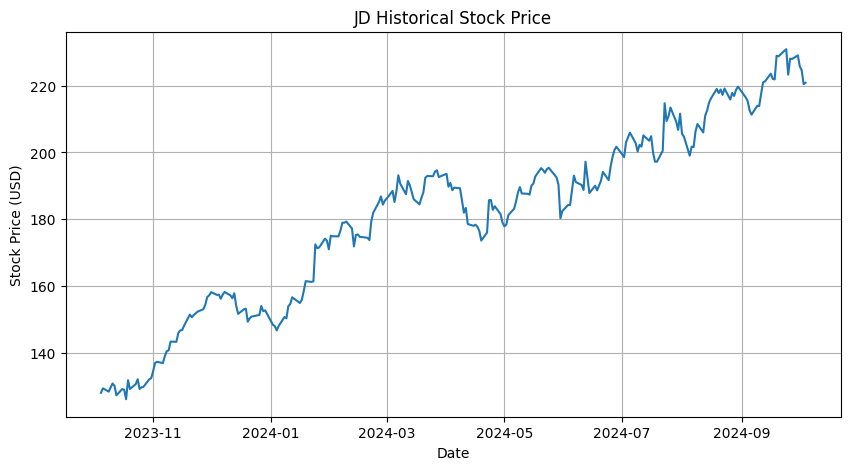

In [8]:
###### Plots of Stock Prices from YF #######

selected_randoms = random.sample(range(1, len(valid_tickers)), 4)

# Loop through the 6 selected random variables
for i, value in enumerate(selected_randoms):
    historical_data = fetch_historical_stock_data(valid_tickers[value])
    plt.figure(figsize=(10, 5))
    plt.plot(historical_data['Close'])
    plt.title(f'{tickers[value]} Historical Stock Price')
    plt.xlabel('Date')
    plt.ylabel('Stock Price (USD)')
    plt.grid(True)

In [9]:

### Live Options Data From 12-Sept-2024 ###

Data_put = pd.DataFrame()
Data_put['stock'] = []
Data_put['expiry_date'] = []
Data_put['strike_price'] = []
Data_put['live_last_price'] = []
Data_put['bsm'] = []
Data_put['sigma'] = []

for ticker in valid_tickers:
    
    #Find list of on market expiration dates between now and 30 days from now
    yfticker = yf.Ticker(ticker)
    
    dates = list(yfticker.options)
    today = datetime.today()
    thirty_days_from_now = today + timedelta(days=30)

    for date in dates:
            
        if datetime.strptime( date, '%Y-%m-%d') > thirty_days_from_now:
            pass
        else:
            put_data = yfticker.option_chain(date).puts
            for index, row in put_data.iterrows():
                
        
                date = parse_contract_symbol(row['contractSymbol'],ticker )['expiration_date']
                price = parse_contract_symbol(row['contractSymbol'],ticker )['strike_price']
                type = parse_contract_symbol(row['contractSymbol'],ticker )['option_type']
            

                #compute BS prediction 
                black_scholes_pred = compute_option_price(ticker_symbol=ticker, T=days_until(date), K=price, option_type='put')

                options_data_one_date = yfticker.option_chain(date)
                d = options_data_one_date.puts

                
                live_last_price = d.loc[d['strike'] == float(price)]['lastPrice'].values[0]
                
            

                sigma = calculate_historical_volatility(fetch_historical_stock_data(ticker))

                new_row = pd.DataFrame({'stock': [ticker], 'expiry_date': [date], 'strike_price' : [price], 'live_last_price':[live_last_price], 'bsm':[black_scholes_pred], 'sigma': [sigma] })
                Data_put=pd.concat([Data_put, new_row], ignore_index=True)


Data_put.to_csv('/Users/judd/Desktop/put_data_sept_13.csv')

/var/folders/8k/9jgfk1f10xd019kt_x6h66yc0000gn/T/ipykernel_73720/2298946174.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bsm = BlackScholesModel(S=fetch_historical_stock_data(ticker_symbol)['Close'][-1], K=K, T_days=T, r=r, sigma=sigma)
/var/folders/8k/9jgfk1f10xd019kt_x6h66yc0000gn/T/ipykernel_73720/2298946174.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bsm = BlackScholesModel(S=fetch_historical_stock_data(ticker_symbol)['Close'][-1], K=K, T_days=T, r=r, sigma=sigma)
/var/folders/8k/9jgfk1f10xd019kt_x6h66yc0000gn/T/ipykernel_73720/2298946174.py:40: FutureWarning: Series.__getitem__ treating keys as 

In [10]:

### Live Options Data From 13-Sept-2024 ###

Data_call = pd.DataFrame()
Data_call['stock'] = []
Data_call['expiry_date'] = []
Data_call['strike_price'] = []
Data_call['live_last_price'] = []
Data_call['bsm'] = []
Data_call['sigma'] = []

for ticker in valid_tickers:
    
    #Find list of on market expiration dates between now and 30 days from now
    yfticker = yf.Ticker(ticker)
    
    dates = list(yfticker.options)
    today = datetime.today()
    thirty_days_from_now = today + timedelta(days=30)

    for date in dates:
            
        if datetime.strptime( date, '%Y-%m-%d') > thirty_days_from_now:
            pass
        else:
            call_data = yfticker.option_chain(date).calls
            for index, row in call_data.iterrows():
        
                date = parse_contract_symbol(row['contractSymbol'],ticker )['expiration_date']
                price = parse_contract_symbol(row['contractSymbol'],ticker )['strike_price']
                type = parse_contract_symbol(row['contractSymbol'],ticker )['option_type']
            

                #compute BS prediction 
                black_scholes_pred = compute_option_price(ticker_symbol=ticker, T=days_until(date), K=price, option_type='call')

                options_data_one_date = yfticker.option_chain(date)
                d = options_data_one_date.calls

                
                live_last_price = d.loc[d['strike'] == float(price)]['lastPrice'].values[0]
                
        

                sigma = calculate_historical_volatility(fetch_historical_stock_data(ticker))

                new_row = pd.DataFrame({'stock': [ticker], 'expiry_date': [date], 'strike_price' : [price], 'live_last_price':[live_last_price], 'bsm':[black_scholes_pred], 'sigma': [sigma] })
                Data_call=pd.concat([Data_call, new_row], ignore_index=True)


Data_call.to_csv('/Users/judd/Desktop/call_data_sept_13.csv')

/var/folders/8k/9jgfk1f10xd019kt_x6h66yc0000gn/T/ipykernel_73720/2298946174.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bsm = BlackScholesModel(S=fetch_historical_stock_data(ticker_symbol)['Close'][-1], K=K, T_days=T, r=r, sigma=sigma)
/var/folders/8k/9jgfk1f10xd019kt_x6h66yc0000gn/T/ipykernel_73720/2298946174.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bsm = BlackScholesModel(S=fetch_historical_stock_data(ticker_symbol)['Close'][-1], K=K, T_days=T, r=r, sigma=sigma)
/var/folders/8k/9jgfk1f10xd019kt_x6h66yc0000gn/T/ipykernel_73720/2298946174.py:40: FutureWarning: Series.__getitem__ treating keys as 

KeyboardInterrupt: 